<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Forest fire analysis
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <b> Machine Learning 2022</b> <br>
    <b>First homework - 22/04/2022<br>
    Erik Bot - 995881 <br>
    <a href="mailto:erik.bot@mail.polimi.it">erik.bot@mail.polimi.it</a><br>
    </div>
    </td>
</tr>
</table>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import scipy
import itertools
import statsmodels.api as sm

from cycler import cycler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn import preprocessing
from scipy.stats import t, f
from scipy import stats


np.random.seed(0)

# Dataset analysis

The research question is how different methereological variables, along with informations on the geography, the days and months of different forest fires describe the area of the latter ones, by using linear regression tools and feature selection ones.

In the first passage of the linear regression analysis, a careful study of the dataset is needed. First of all, we can notice that the output variable 'area' is skewed towards 0 (because all the forest fires under 100 hectares were approximated to 0), so a logarithm trasformation (in particular a ln(x+1) transformation) can help to better distinguish the data. We also have to remove the (few) missing values, along with adjusting the indexes. Another problem that has to be tackled is the presence of some numerical variables saved as objects (due to the previous presence of 'Missing' values). This variables have to be transformed to floats or integers. In the end, we obtain a dataset with 510 observations and 13 features (12 used as input variables, 1 as output).

In [3]:
ff_data = pd.read_csv("forestfires.csv")

ff_data['logArea'] = 0.0

for index, i in enumerate(ff_data['area']):
    ff_data.loc[index, 'logArea'] = np.log(ff_data.loc[index, 'area'] + 1)


ff_data = ff_data.drop('area', 1)

for col in ff_data.columns:
    ff_data = ff_data[ff_data[col] != 'Missing']

for i in ff_data:
    if i != 'month' and i != 'day':
        if ff_data.dtypes[i] == 'object':
            ff_data[i] = pd.to_numeric(ff_data[i])
            
ff_data.reset_index(drop=True, inplace=True)
ff_data.index = ff_data.index + 1

ff_data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,logArea
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871
507,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592
508,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.498152
509,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000


## Plots

A scatterplot between the output variable and the input variables can help to better visualize the problem. We can see that the variables rain, ISI, RH, wind and FFMC have clearly some outliers. We can also see that august and september show the highest values of area, along with the highest number of recorder forest firest. Visually, we cannot see any particular relationship between the area and the other numerical variables. December is also the only month were we don't see any forest with a very small area (which, in this dataset, is put to a 0 value).

<AxesSubplot:xlabel='X', ylabel='logArea'>

<AxesSubplot:xlabel='Y', ylabel='logArea'>

<AxesSubplot:xlabel='month', ylabel='logArea'>

<AxesSubplot:xlabel='day', ylabel='logArea'>

<AxesSubplot:xlabel='FFMC', ylabel='logArea'>

<AxesSubplot:xlabel='DMC', ylabel='logArea'>

<AxesSubplot:xlabel='DC', ylabel='logArea'>

<AxesSubplot:xlabel='ISI', ylabel='logArea'>

<AxesSubplot:xlabel='temp', ylabel='logArea'>

<AxesSubplot:xlabel='RH', ylabel='logArea'>

<AxesSubplot:xlabel='wind', ylabel='logArea'>

<AxesSubplot:xlabel='rain', ylabel='logArea'>

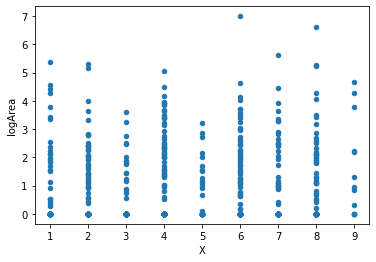

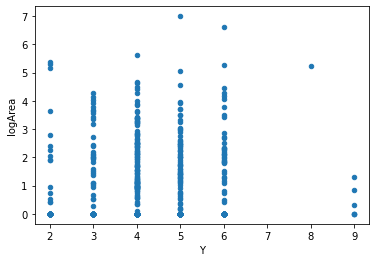

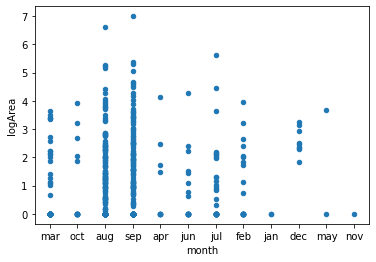

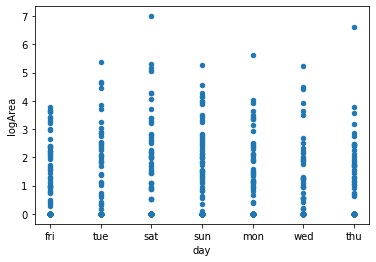

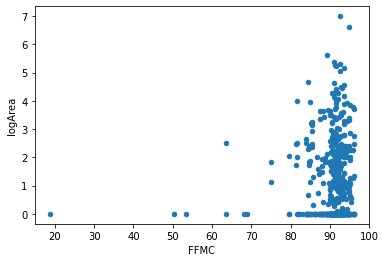

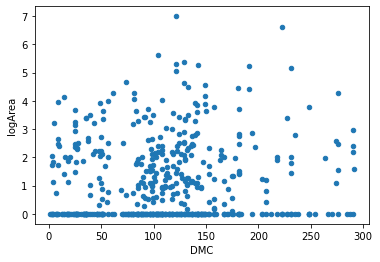

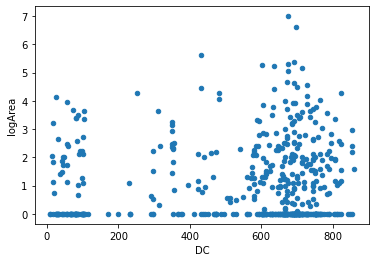

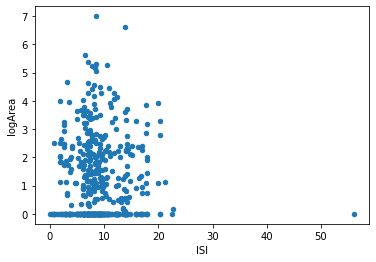

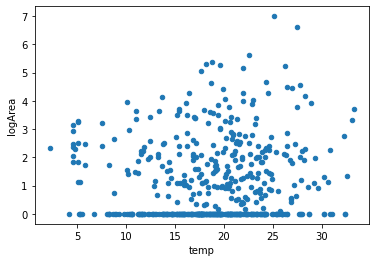

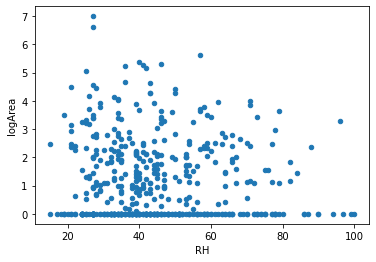

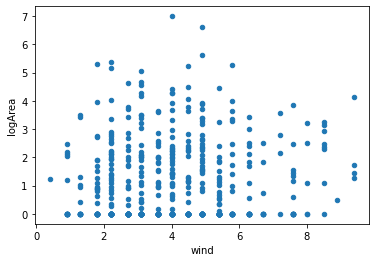

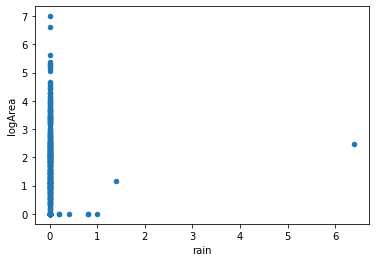

In [4]:
for i in ff_data.columns:
    if i != 'logArea':
        ff_data.plot.scatter(i, 'logArea')

After the scatterplot of the (log) area against the other variables, an helpful graph is the pairplot graph, which helps to visualize possible relatioships between the input variables. Visually, we can see only a few possible relationships between variables, such as DC and DMC or FFMC and ISI (as reported in licterature).

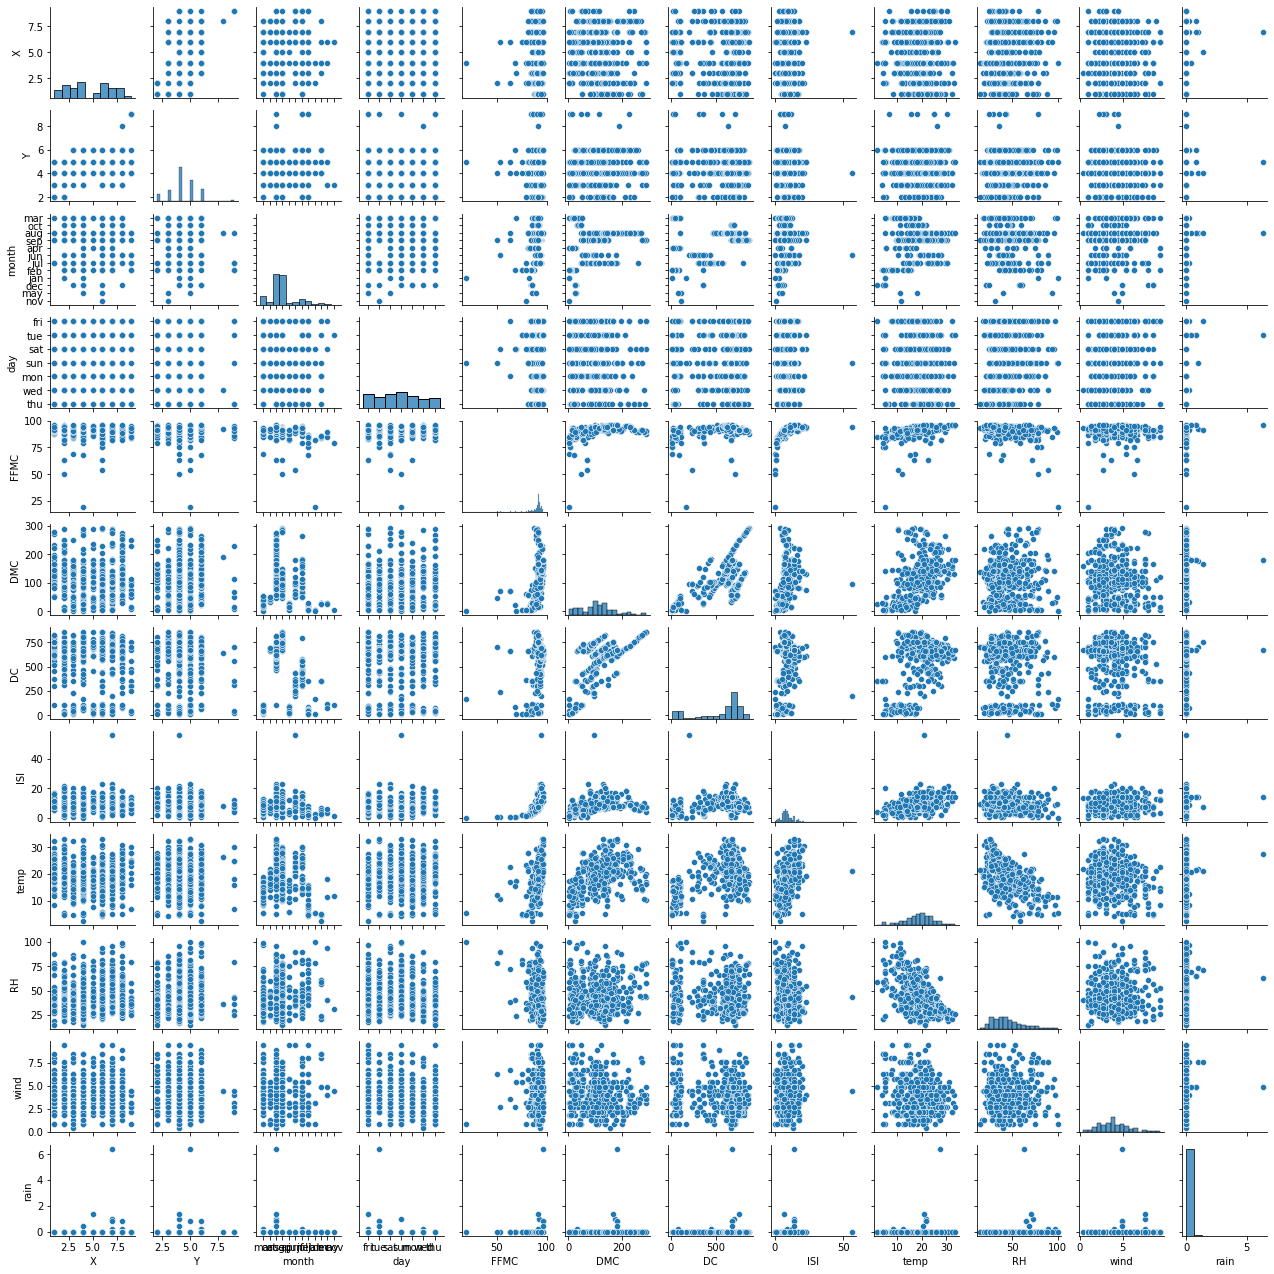

In [5]:
sns.pairplot(ff_data, height=1.5, vars = [f for f in ff_data.columns if f != 'logArea'])

Another helpful tool is the correlation matrix, which enhances the visual analysis with quantitative data. We can see that logArea has no particularly meaninful correlations with the other variables, while we have a score of 0.53 for FFMC and ISI, as we could see from the pairplot, and also a score of 0.68 for DMC and DC. The relationships between this 4 variables was expected, since they can be computed by different non-linear formulas that link them. We can also see that temperature and RH have a negative relationship, with a score of -0.53. Also the X and Y variables are mildly correlated, with a score of 0.54. 
On the other hand, the logarithm of the area doesn't seem to be correlated to any other variable.

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,logArea
X,1.000000,0.540240,-0.023690,-0.051064,-0.090012,0.005058,-0.054259,0.087517,0.015556,0.066410,0.069035
Y,0.540240,1.000000,-0.048911,0.001715,-0.102601,-0.028807,-0.026076,0.059323,-0.023414,0.033509,0.040360
FFMC,-0.023690,-0.048911,1.000000,0.381881,0.329088,0.531778,0.430595,-0.302314,-0.027218,0.056876,0.048351
DMC,-0.051064,0.001715,0.381881,1.000000,0.683729,0.305739,0.470533,0.068518,-0.105346,0.075307,0.068603
DC,-0.090012,-0.102601,0.329088,0.683729,1.000000,0.227763,0.494281,-0.038763,-0.200552,0.036027,0.067013
ISI,0.005058,-0.028807,0.531778,0.305739,0.227763,1.000000,0.390624,-0.129945,0.111681,0.068026,-0.009624
temp,-0.054259,-0.026076,0.430595,0.470533,0.494281,0.390624,1.000000,-0.528333,-0.223604,0.069912,0.055196
RH,0.087517,0.059323,-0.302314,0.068518,-0.038763,-0.129945,-0.528333,1.000000,0.068183,0.099895,-0.057215
wind,0.015556,-0.023414,-0.027218,-0.105346,-0.200552,0.111681,-0.223604,0.068183,1.000000,0.061824,0.071581
rain,0.066410,0.033509,0.056876,0.075307,0.036027,0.068026,0.069912,0.099895,0.061824,1.000000,0.022611


[ 0.06903548  0.04035975  0.04835065  0.06860338  0.06701331 -0.00962443
  0.05519643 -0.05721455  0.07158136  0.02261075  1.        ]


<AxesSubplot:>

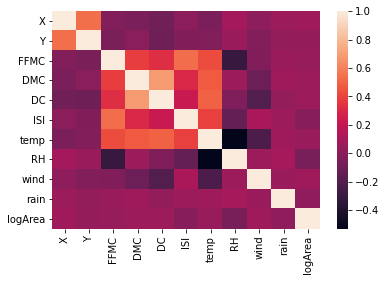

In [6]:
ff_data.corr()

print(ff_data.corr().to_numpy()[:,-1])
sns.heatmap((ff_data).corr()) 

## Dataset transformations

We could convert the cathegorical variables into simpler ones, by grouping them. In particular, the days of the week can be grouped in workdays and weekends, since on the weekends the visitors increase in number (which then increases the probability of fires). Months instead could be grouped in seasons, since we would expect that during summer the fires would increase, on the contrary to winter. Since this procedure, which approximates the data, showed no particular improvement, it will be only presented, but not run.

In [7]:
#ff_data['daytype'] = 'zero'

#for i in range(0, len(ff_data['daytype'])):
#    if ff_data['day'][i] in ['mon', 'tue', 'wed', 'thu', 'fri']:
#        ff_data['daytype'][i] = 'weekday'
#    else:
#        ff_data['daytype'][i] = 'weekend'
        
#ff_data['season'] = 'zero'

#for i in range(0, len(ff_data['season'])):
#    if ff_data['month'][i] in ['dec', 'jan', 'feb']:
#        ff_data['season'][i] = 'winter'
#    elif ff_data['month'][i] in ['mar', 'apr', 'may']:
#        ff_data['season'][i] = 'spring'
#    elif ff_data['month'][i] in ['jun', 'jul', 'aug']:
#        ff_data['season'][i] = 'summer'
#    else:
#        ff_data['season'][i] = 'autumn'

#ff_data['daytype_season'] = 'zero'
#
#for i in range(0, len(ff_data['daytype_season'])):
#    ff_data['daytype_season'][i] = ff_data['daytype'][i] + '_' + ff_data['season'][i]

#ff_data = ff_data.drop('month', 1)
#ff_data = ff_data.drop('day', 1)
#ff_data = ff_data.drop('daytype', 1)
#ff_data = ff_data.drop('season', 1)

We could also perform an outlier selection and elimination, because of the high-leverage points that can be seen from the scatterplots of the features against the logarithm. In particular, the features of FFMC, ISI, RH, wind and rain show significant outliers. Again, this procedure shows no particular increase in the values of the performance scores, so it will not be run.

In [8]:
#for x in ['FFMC','ISI','RH','wind','rain']: 
#    nas = list(np.abs(stats.zscore(ff_data[x])) > 3)
#    indices = [i for i, x in enumerate(nas) if x == True]
#    for ind in indices:
#        ff_data.at[ind, x] = None

#ff_data=ff_data.dropna()

Eventually, the normalization of the data is suggested by licterature, but again, this doesn't show any increase in the performance of the model.

In [9]:
#import statistics
#for col in ff_data.columns:
#    if col != 'day' and col != 'month' and col != 'logArea':
#        ff_data[col] = (ff_data[col] - statistics.mean(ff_data[col]))/(statistics.stdev(ff_data[col]))

A procedure which is necessary for a correct linear regression analysis is the conversion of the chategorical variables into dummy variables, via the one hot encoding. This allows us to quantitatively assess the differences between the different months and days with respect to the area of forest fires.

In [10]:
ff_data = pd.get_dummies(data=ff_data, columns= ['day', 'month'])

ff_data.head()
ff_data.shape

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
1,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,0,1,0,0,0,0
2,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,0,1,0
3,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,0,1,0
4,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,0,1,0,0,0,0
5,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,1,0,0,0,0


(510, 30)

# Linear regression

After all the preliminar processes, the X and y matrices need to be built, using as output the logarithm of the area and as input all the other variables.

In [11]:
X_all_features = [i for i in ff_data if i != 'logArea']

X = ff_data[X_all_features].to_numpy()

y = ff_data['logArea'].to_numpy()

print("X.shape", X.shape, "X.dtype", X.dtype)
print("y.shape", y.shape, "y.dtype", y.dtype)

X.shape (510, 29) X.dtype float64
y.shape (510,) y.dtype float64


Using then the 'train_test_split' function of skilearn, we can split our data into train and test matrices, which allows us to train the model on a subset of our data and then test the trained model on other recordings. We use a test size of 30%.

In [12]:
ff_test_size = 0.3
ff_test_seed = 40

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ff_test_size, random_state=ff_test_seed)
print('X_train.shape ', X_train.shape)
print('X_test.shape ', X_test.shape)
print('y_train.shape ', y_train.shape)
print('y_test.shape ', y_test.shape)

X_train.shape  (357, 29)
X_test.shape  (153, 29)
y_train.shape  (357,)
y_test.shape  (153,)


Finally, we can apply the linear regression model, trained on the X_train and y_train matrices and then tested on X_test.We can see that the test R2 score is much worse than the train R2 score, and actually is negative. Also the Mean Squared Error is higher in the test group. This indicates that considering all the different variables doesn't correctly describe the area of forest fires, so a procedure of feature selection will be needed.

In [13]:
model = LinearRegression(fit_intercept=True) 
model = model.fit(X_train, y_train) 

y_predict_test = model.predict(X_test)
y_predict_train = model.predict(X_train)


print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.11998050208180688
Train MSE score  1.695076535467649
Test R2 score  -0.145271375206935
Test MSE score  2.3377163107227217


We can then look at the different coefficients associated to all the variables.

In [14]:
for idx, col_name in enumerate(X_all_features):
    print("The coefficient for {} is {}".format(col_name, model.coef_[idx]))
print("The intercept is {:0.3f}".format(model.intercept_))

The coefficient for X is 0.05358795362291089
The coefficient for Y is 0.026534480094867995
The coefficient for FFMC is 0.014694762248391705
The coefficient for DMC is 0.002453254014906967
The coefficient for DC is -0.0022235329716174335
The coefficient for ISI is -0.010697984196838458
The coefficient for temp is 0.04218380052126432
The coefficient for RH is 0.007226518827419249
The coefficient for wind is 0.09589268937134172
The coefficient for rain is 0.07416849035929009
The coefficient for day_fri is -0.2166774300467292
The coefficient for day_mon is -0.027610393852069502
The coefficient for day_sat is 0.21062659789010274
The coefficient for day_sun is 0.1369319288472129
The coefficient for day_thu is -0.0802414844279637
The coefficient for day_tue is -0.005667476798372571
The coefficient for day_wed is -0.017361741612177885
The coefficient for month_apr is 0.011299011535147356
The coefficient for month_aug is -0.08772591988135589
The coefficient for month_dec is 1.5193158026443025
T

## Hypothesis testing

To assess the actual impact of the different variables, we have to compute the T-test and F-test, after defining the needed functions that allow us to compute the RSS (Residual Sum of Squares) and TSS (Total Sum of Squares), along with the multiple least squares, that allows us to compute the linear regression.

When testing multiple variables at the same time, the T-test might make type I errors, so we need to consider also the F-test.

In [15]:
def rss(y_true, y_pred):
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

In [16]:
def tss(y):
    return np.sum((y - y.mean()) ** 2)

In [17]:
def multiple_least_squares(X, y):
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred

We can define a F-test function which takes into consideration all the variables (as presented in the theoretical classes):

In [18]:
def Ftest(data, y):
    
    X_complete = data.to_numpy()
    y = y.to_numpy()
    n = X_complete.shape[0]
    
    betas_complete, y_pred = multiple_least_squares(X_complete, y)    
    rss_complete = rss(y, y_pred)
    tss_complete = tss(y)
    nf_complete = X_complete.shape[1]

    F_num = (tss_complete - rss_complete) / nf_complete
    F_den = rss_complete / (n - nf_complete - 1)
    F = F_num / F_den

    p_value = f.sf(F, nf_complete, n - nf_complete - 1)
    
    return p_value, F

At the same time, we can define a function which performs the F-test only on a subset of features:

In [19]:
def Ftest_restricted(data, y, subset_features):
    
    X_complete = data.to_numpy()
    y = y.to_numpy()
    n = X_complete.shape[0]
    
    betas_complete, y_pred = multiple_least_squares(X_complete, y)    
    rss_complete = rss(y, y_pred)
    nf_complete = X_complete.shape[1]
    
    notS = data.columns.difference(subset_features)
    X_restr = data[notS].to_numpy()
    betas_restr, y_pred = multiple_least_squares(X_restr, y)

    rss_restr = rss(y, y_pred)
    nf_restr = X_restr.shape[1]

    q = nf_complete - nf_restr

    F_num = (rss_restr - rss_complete) / q
    F_den = rss_complete / (n - nf_complete - 1)
    F = F_num / F_den

    p_value = f.sf(F, q, n - nf_complete - 1)
    return p_value, F

Finally, we can implement the function that provides a summary of the T-tests:

In [20]:
def show_stats(X, y, betas, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features
    
    if X.shape[1] + 1 == betas.shape[0]:
        X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    
    pred = X.dot(betas).reshape(-1)
    betas = betas.reshape(-1)
    y = y.reshape(-1)
    RSE = ((y-pred)**2).sum()/(n_samples - n_features)

    se2_b = RSE*(abs(np.linalg.inv(np.dot(X.T, X)).diagonal()))
    se_b = np.sqrt(se2_b)
    t_stat_b = (betas - 0) / se_b

    p_values = np.array([2*t.sf(np.abs(t_stat), deg) for t_stat in t_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = se_b
    df["t-stat"] = t_stat_b
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    RSS = np.sum((y - pred)**2)
    MSE = RSS/y.shape[0]
    
    return df

As can be seen by the T-test p-values (in the following table), none of the p-values associated to the coefficients of the different variables are significantly different from 0. The only variable that would be included with an alpha of 0.05 would be wind.

In [21]:
betas = np.array([model.intercept_, *model.coef_]).reshape(-1, 1)
all_stats = show_stats(X_train, y_train, betas, ['Intercept', *X_all_features], alpha=0.05)

all_stats

X_selected_features = [f for i, f in enumerate(all_stats['Name']) if all_stats['reject H0'][i] == True]

,Name,Coefficients,Standard Errors,t-stat,p-value,reject H0
0,Intercept,-1.166955,9.995380e+06,-1.167494e-07,1.000000,False
1,X,0.053588,3.800413e-02,1.410056e+00,0.159471,False
2,Y,0.026534,7.305557e-02,3.632095e-01,0.716682,False
3,FFMC,0.014695,1.709185e-02,8.597528e-01,0.390553,False
4,DMC,0.002453,2.310629e-03,1.061726e+00,0.289141,False
5,DC,-0.002224,1.670675e-03,-1.330919e+00,0.184140,False
6,ISI,-0.010698,1.978069e-02,-5.408297e-01,0.588992,False
7,temp,0.042184,2.718882e-02,1.551513e+00,0.121743,False
8,RH,0.007227,7.655468e-03,9.439683e-01,0.345881,False
9,wind,0.095893,4.444541e-02,2.157538e+00,0.031689,True


As we can see also from the F-test, which considers as the null hypothesis that all features are equal to 0, there is evidence to reject H0, so at least one feature is useful.

In [22]:
alpha = 0.05

X_train_ff = pd.DataFrame(X_train, columns=X_all_features)
y_train_ff = pd.DataFrame(y_train)

X_test_ff = pd.DataFrame(X_test, columns = X_all_features)
y_test_ff = pd.DataFrame(y_test)

p_value, F = Ftest(X_train_ff, y_train_ff)
print("p-value =", p_value)
print("F-stat =", F)
if p_value < alpha:
    print("Reject H0: There is evidence to say that at least one of the features is useful")
else:
    print("Do not Reject H0: There is NO evidence to say that at least one of the features is useful")

p-value = 0.04100973156521099
F-stat = 1.5373336564020648
Reject H0: There is evidence to say that at least one of the features is useful


We could then try to consider only wind, as it is the only parameter that has a p-value lower then 0.05. This is because an analysis considering all features could be too complex and with a high chance of overfitting (high variance, which depends on the number of features/parameters). Considering only wind, on the other hand, could be too simple (high bias).

In [23]:
X_selected_features = ['wind']

X_selected = ff_data[X_selected_features].to_numpy()

ff_test_size = 0.3
ff_test_seed_v2=39
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y,
                                                                                        test_size=ff_test_size,
                                                                                        random_state=ff_test_seed_v2)

model_s = LinearRegression()                       
model_s = model_s.fit(X_train_selected, y_train_selected)        
y_predict_test_s = model_s.predict(X_test_selected)     
y_predict_train_s = model_s.predict(X_train_selected)

print('Performance evaluator: \n')
print("Train R2 score ", r2_score(y_train_selected, y_predict_train_s))
print("Train MSE score ", mean_squared_error(y_train_selected, y_predict_train_s))

print("Test R2 score ", r2_score(y_test_selected, y_predict_test_s))
print("Test MSE score ", mean_squared_error(y_test_selected, y_predict_test_s), '\n')

Performance evaluator: 

Train R2 score  0.0064425807554903125
Train MSE score  1.9411385020238194
Test R2 score  0.0007011978915324457
Test MSE score  1.976646776814326 



## Polynomial degree analysis

We can then try to assess how the R2 and MSE scores vary along with different polynomial degrees. With these information, we can then obtain the best degree. We performed a hyperparameters selection, by cross validation. We can simulate to have multiple training and validation sets, called folds. We then iteratively reserve a part of the training set for validation and train the model on the remaining data. The GridSearchCV class performs cross validation while also searching among a set of different hyperparameters. In this way, we can select the best degree. We will then apply the same procedure when a feature selection will occur (which will be more meaningful then applying it only to one feature).

The table below shows the scores of the different folds and the average score, which determines the best degree. In this case, we can see that the best degree is one.

In [24]:
model_poly_s = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

r2_scorer = make_scorer(r2_score)

parameters = {'poly__degree': list(range(1,5))}

cv = GridSearchCV(model_poly_s, parameters, scoring=r2_scorer, cv=20, refit=True)
print('Grid search: \n')
cv.fit(X_train_selected, y_train_selected)

print('Summary table: \n')
pd.DataFrame(cv.cv_results_)

print("Best degree:", cv.best_params_['poly__degree'])

Grid search: 



GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

Summary table: 



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002901,0.001221,0.001952,0.001118,1,{'poly__degree': 1},-0.028741,-0.111300,-0.335082,0.029071,...,0.007451,0.008254,0.007194,-0.032729,-0.301426,-0.102045,-0.191866,-0.071711,0.102883,1
1,0.002652,0.001064,0.001254,0.000841,2,{'poly__degree': 2},-0.106142,-0.150930,-0.324006,0.074875,...,-0.113771,0.039135,0.018395,-0.022094,-0.348713,-0.067961,-0.200973,-0.082700,0.115181,2
2,0.002200,0.000679,0.001301,0.000459,3,{'poly__degree': 3},-0.050697,-0.196393,-0.285851,0.096227,...,-0.013171,0.049319,0.030469,0.001694,-0.441142,-0.083973,-0.157362,-0.084875,0.132925,3
3,0.002402,0.000801,0.001399,0.000584,4,{'poly__degree': 4},-0.152191,-0.223553,-0.213415,0.105737,...,-0.007664,0.067067,0.011517,0.014377,-0.414720,-0.081514,-0.176825,-0.089045,0.130584,4


Best degree: 1


The test score is higher than the one considering the model with all features (suggesting that a feature selection is needed, as expected). We can also see that the train score is lower than the test one, which means that the result highly depends on the split between train and test (which is random), rather than one the model itself.

In [25]:
model_best_b = cv.best_estimator_
y_predict = model_best_b.predict(X_test_selected)
test_score = r2_score(y_test_selected, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train R2 score:", cv.best_score_)
print("Test R2 score:", test_score)

Best degree: 1
Train R2 score: -0.07171094812900178
Test R2 score: 0.0007011978915324457


We then have to implement a method that allows us to test different metrics. In particular, we will ask the user to provide an evaluator function used to train a model and evaluate it against a specific training set.
We will create a function that, given a scorer, generates the evaluator function that uses that scorer to evaluate the model.

In [26]:
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator

In [27]:
def estimate_sigma(Xtrain_pd, ytrain):
    
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def adj_r2(y_pred, y_true, n, d):
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))


In [28]:
def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

sigma = estimate_sigma(X_train_ff, y_train)

# Feature selection

## Best subset feature selection

We then can implement a forward and backward feature selection procedure, given that we have an high number of features and the best subset feature selection (which considers all possible combinations of the input features) would be too computationally costly. Forward and backward feature selection procedures are instead gready approaches, which sacrifice accuracy to gain computational time. I will nonetheless provide the code of the best subset feature selection below, along with the functions of the forward and backward feature selections.

In [29]:
def subset_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                     candidates_evaluator, candidates_argbest, 
                     subsets_evaluator, subsets_argbest,       
                     test_evaluator=None, test_argbest=None, 
                     candidates_scorer_name=None, 
                     subsets_scorer_name=None,     
                     verbose=True, weight_step3=0):  
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    
    subsets_test = [] 
    subsets_metric = []        
    subsets_best_features = []
    
    plt.figure()
    candidate_fig = plt.subplot(111) 
    num_evaluations = 0        
    
    for dim in range(num_features+1):
        candidate_metrics = [] 
        candidate_models = []  
        
        dim_subsets = get_subsets(Xtrain_pd, dim=dim)
        for Xtrain_sub in dim_subsets:
            
            if Xtrain_sub.shape[-1] == 0:
                
                model = DummyRegressor()
            else:
                model = LinearRegression(fit_intercept=True)
            
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([dim]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        idx_best_candidate = candidates_argbest(candidate_metrics)
        
        best_features = dim_subsets[idx_best_candidate].columns.tolist()
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        subsets_best_features.append(best_features)
        
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = dim_subsets[idx_best_candidate]
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_subset_Xtrain.columns.tolist()]
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()


In [30]:
def get_subsets(X_pd, dim):
    feature_names = X_pd.columns.tolist()
    
    subset_names = itertools.combinations(feature_names, dim)
    
    data_subsets = [X_pd[list(fnames)] for fnames in subset_names]
    return data_subsets

In [31]:
#X_train_pd = pd.DataFrame(X_train, columns=X_all_features)
#y_train_pd = pd.DataFrame(y_train)
#X_test_pd = pd.DataFrame(X_test, columns = X_all_features)
#y_test_pd = pd.DataFrame(y_test)

#sigma = estimate_sigma(X_train_pd, y_train)
#subset_selection(X_train_pd, y_train, X_test_pd, y_test,
#                 get_evaluator(make_scorer(rss)), np.argmin, 
#                 get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, 
#                 get_evaluator(make_scorer(mean_squared_error)), np.argmin, 
#                 candidates_scorer_name="RSS",
#                 subsets_scorer_name="BIC",
#                 verbose=True)

## Forward and Backward feature selection

The forward feature selection technique has a greedy approach, meaning that it starts from a model with one parameter and checks which feature has the highest score. Then, it keeps fixed that feature and adds one feature one step at a time, always keeping fixed the features that give the model with the highest score.

In [32]:
def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, 
                      subsets_evaluator, subsets_argbest,       
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  
                      subsets_scorer_name=None,     
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    
    subsets_test = []
    subsets_metric = []        
    subsets_best_features = [] 
    plt.figure()
    candidate_fig = plt.subplot(111) 
    num_evaluations = 0       
    
    selected_features = []  
    all_features = Xtrain_pd.columns
    
    
    
    model = DummyRegressor()
    
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    for dim in range(num_features):
        candidate_metrics = [] 
        candidate_models = []  
        
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
            
        idx_best_candidate = candidates_argbest(candidate_metrics)
        
        selected_features.append(remaining_features[idx_best_candidate])
        
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim + 1, dim + 1, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()
    return subsets_best_features[best_subset_idx]

The backward selection function follows the same reasoning (the one presented in the practical classes) as the forward selection one, with a slight modification of the code in order to select step by step, starting from the model with the most features and removing one at a time, the model with the best score.

In [33]:
def backward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, 
                      subsets_evaluator, subsets_argbest,       
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  
                      subsets_scorer_name=None,     
                      verbose=True, weight_step3=0):   
    
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    
    subsets_test = []
    subsets_metric = []        
    subsets_best_features = [] 
    plt.figure()
    candidate_fig = plt.subplot(111) 
    num_evaluations = 0       
      
    all_features = Xtrain_pd.columns
    
    selected_features = list(all_features)
    
    model = DummyRegressor()
    
    dim = 1
    while dim < num_features:
        
        candidate_metrics = [] 
        candidate_models = []  
        to_remove_features = []
        
        for new_column in selected_features:
            # this selects the model excluding one feature at a time, starting from the lastly selected model
            Xtrain_sub = Xtrain_pd[[x for x in selected_features if x != new_column]].to_numpy() 
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            to_remove_features.append(new_column)
            num_evaluations += 1
            
        idx_best_candidate = candidates_argbest(candidate_metrics)
        
        # this selects the feature that, when removed, provides the model with the highest score
        to_remove_feature = to_remove_features[idx_best_candidate]
        
        selected_features.remove(to_remove_feature)
        
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(len(best_features), len(best_features), best_features))
            print("M{} subset score (3.): {}".format(len(best_features), score))
            
        dim = dim + 1
        
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(num_features - best_subset_idx - 1))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()
    
    return subsets_best_features[best_subset_idx]

We then implement a cross validation procedure, along with the validation and cross validation evaluators.

In [34]:
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=ff_test_seed)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator

We then apply a cross validation with both the forward and the backward feature selection (also changing the cv inside the get_cv_evaluator function), obtaining two different models.
For both the forward and backward feature selection we select four features, which are the months of September, December and May and wind, which was the only feature that had a (somewhat) significant coefficient. This is actually an important result, that means that the selected model is the best one for two independent techniques. It also suggests that the implemented Backward selection function is correct. The only difference is that the backward trains a slighlty smaller number of models.

In [35]:
type(X_train_ff)

pandas.core.frame.DataFrame

In [36]:
LUCa

NameError: name 'LUCa' is not defined

In [ ]:
cv = 20
sigma = estimate_sigma(X_train_ff, y_train)
X_forward_features = forward_selection(X_train_ff, y_train, X_test_ff, y_test,
                                       get_evaluator(make_scorer(r2_score)), np.argmax, 
                                       get_cv_evaluator(make_scorer(r2_score), cv = cv), np.argmax, 
                                       get_evaluator(make_scorer(r2_score)), np.argmax, 
                                       candidates_scorer_name="cv(R^2)",
                                       subsets_scorer_name="cv(R^2)",
                                       verbose=True, weight_step3=10)

In [ ]:
cv = 20
sigma = estimate_sigma(X_train_ff, y_train)
X_backward_features = backward_selection(X_train_ff, y_train, X_test_ff, y_test,
                                         get_evaluator(make_scorer(r2_score)), np.argmax,
                                         get_cv_evaluator(make_scorer(r2_score), cv = cv), np.argmax,
                                         get_evaluator(make_scorer(r2_score)), np.argmax, 
                                         candidates_scorer_name="cv(R^2)",
                                         subsets_scorer_name="cv(R^2)",
                                         verbose=True, weight_step3=10)

We then consider the model with only the selected features by the forward and backward feature selection and check the score.

Of course, being the models the same, the scores will be equal. The doubled code was kept in case of different parameters along the analysis that could lead to different models.

In [ ]:
X_forward = ff_data[X_forward_features].to_numpy()
y_forward = ff_data['logArea'].to_numpy()
X_train_small_f, X_test_small_f, y_train_small_f, y_test_small_f = train_test_split(X_forward, y_forward,
                                                                test_size=ff_test_size, 
                                                                random_state=ff_test_seed_v2)

model_f = LinearRegression(fit_intercept = True)                       
model_f = model_f.fit(X_train_small_f, y_train_small_f)      
y_predict_test_f = model_f.predict(X_test_small_f)     
y_predict_train_f = model_f.predict(X_train_small_f)

print('\033[1;12m Forward \033[0;0m \n')

print('Model:', X_forward_features, '\n')
print("Train R2 score ", r2_score(y_train_small_f, y_predict_train_f))
print("Train MSE score ", mean_squared_error(y_train_small_f, y_predict_train_f))

print("Test R2 score ", r2_score(y_test_small_f, y_predict_test_f))
print("Test MSE score ", mean_squared_error(y_test_small_f, y_predict_test_f), '\n')

X_backward = ff_data[X_backward_features].to_numpy()
y_backward = ff_data['logArea'].to_numpy()
X_train_small_b, X_test_small_b, y_train_small_b, y_test_small_b = train_test_split(X_backward, y_backward,
                                                                test_size=ff_test_size, 
                                                                random_state=ff_test_seed_v2)

model_b = LinearRegression(fit_intercept = True)                       
model_b = model_b.fit(X_train_small_b, y_train_small_b)      
y_predict_test_b = model_b.predict(X_test_small_b)     
y_predict_train_b = model_b.predict(X_train_small_b)

print('............ \n')
print('\033[1;12m Backward \033[0;0m \n')

print('Model:', X_backward_features, '\n')
print("Train R2 score ", r2_score(y_train_small_b, y_predict_train_b))
print("Train MSE score ", mean_squared_error(y_train_small_b, y_predict_train_b))

print("Test R2 score ", r2_score(y_test_small_b, y_predict_test_b))
print("Test MSE score ", mean_squared_error(y_test_small_b, y_predict_test_b))


### Degree analysis

Again, we can try to find the best degree considering only the features selected with the forward and backward feature selection. We can see that for both models the best degree is still 1.

In [ ]:
model_poly_f = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

r2_scorer = make_scorer(r2_score)

parameters = {'poly__degree': list(range(1,5))}

cv = GridSearchCV(model_poly_f, parameters, scoring=r2_scorer, cv=20, refit=True)
print('Grid search: \n')
cv.fit(X_train_small_f, y_train_small_f)

print('Summary table: \n')
pd.DataFrame(cv.cv_results_)

print("Best degree for the selected features:", cv.best_params_['poly__degree'])

degree_forward = cv.best_params_['poly__degree']

## Lasso feature selection

In the end, we can perform a Lasso feature selection, by applying a penalty to the linear regression function, and, by the geometrical shape of the constrain, we can eliminate some features, based on the penalty. We can try to modify the penalty in order to see what features go to 0 before (less meaningful) and what features instead go to 0 last (the most meaningful ones).

In [ ]:
lambda_vals = np.linspace(1e-4, 0.5, 100)
betas = []


X_std = preprocessing.scale(X_train_ff)

for l in lambda_vals:
    model_lasso = linear_model.Lasso(alpha=l)
    model_lasso.fit(X_std, y_train)
    beta = model_lasso.coef_.reshape(-1)
    
    betas.append(beta)
    
betas = np.stack(betas, axis=1)  

for beta, name in zip(betas, X_all_features):
    plt.plot(lambda_vals, beta, label=name)

plt.legend()
plt.xlabel("lambda")
plt.ylabel("beta")

We can then order the features based on the number of zeros coefficients they have (varying C). The ones with the less zeros are the ones that go to zero later, meaning that they are the most meaningful ones. We can then compare the different models considering a different amount of features, starting from the most meaningful ones and going back. We can then select a model with 2 features: the months of December and September.

In [ ]:
d = {}

for beta, name in zip(betas, X_all_features):
    beta_no_0 = [n for n in beta if n != 0.0]
    d[name] = len(beta_no_0)                    # selecting the number of non-zero coefficients per feature

sorted_features = sorted(d, key=d.get)[::-1]    # ordering the features with respect to the number of non-zero coefficients (which means ordering for importance)

# creating a dictionary with, for every model computed by adding one feature at a time (in order of importance), the associated r2 score

scores = {}

for i in range(1, len(sorted_features)+1):
    features = sorted_features[0:i]
    X_features = ff_data[features].to_numpy()
    y_features = ff_data['logArea'].to_numpy()
    X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(X_features, y_features,
                                                                                            test_size=ff_test_size,
                                                                                            random_state=ff_test_seed_v2)

    model_l = LinearRegression(fit_intercept = True)                       
    model_l = model_l.fit(X_train_features, y_train_features)      
    y_predict_test_features = model_l.predict(X_test_features)     
    y_predict_train_features = model_l.predict(X_train_features)
    
    scores[i] = [r2_score(y_test_features, y_predict_test_features), mean_squared_error(y_test_features, y_predict_test_features)]

# choosing the best model by looking at the r2 score

r2 = None
MSE_score = None
X_lasso_features = None

for score in scores.items():
    if X_lasso_features is None:
        r2 = score[1][0]
        MSE_score = score[1][1]
        X_lasso_features = sorted_features[0:score[0]]
    else:
        if score[1][0] > r2:
            r2 = score[1][0]
            MSE_score = score[1][1]
            X_lasso_features = sorted_features[0:score[0]]
            
print('The best model has:', len(X_lasso_features), 'features')
print('The best model is:', X_lasso_features)
print('The associated test r2 score is:', r2)
print('The associated MSE score is:', MSE_score)

### Cross validated Lasso

We can then look at the features selected by cross validation.

In [ ]:
lambda_vals = np.linspace(1e-4, 0.5, 500)

X_std = preprocessing.scale(X_train_ff)

model_lasso = linear_model.LassoCV(n_alphas = len(lambda_vals), alphas=lambda_vals, fit_intercept = True, cv = 20)
model_lasso.fit(X_std, y_train)
betas = model_lasso.coef_.reshape(-1)

lasso_CV_features = []

for ind, num in enumerate(betas):
    for i, f in enumerate(X_all_features):
        if num != 0.0 and num != -0.0:
            if ind == i:
                lasso_CV_features.append(f)

print(f'The model selected by CV is: {lasso_CV_features}')

We can see that the features selected with the cross validated Lasso are different than the ones selected previously. By a fest check, we can see that the cross validation-selected features are one of the models that was taken into consideration by the previous code. This means that, for this particular split of the data between train and test, a simpler model has a higher r2 score, while, on the other hand, the best model on the whole dataset is the one selected with cross validation.

In [ ]:
if lasso_CV_features.sort() == sorted_features[0:5].sort():
    print('The two models are equal. \n')

X_lasso_cv = ff_data[lasso_CV_features].to_numpy()
y_lasso_cv = ff_data['logArea'].to_numpy()
X_train_lasso_cv, X_test_lasso_cv, y_train_lasso_cv, y_test_lasso_cv = train_test_split(X_lasso_cv, y_lasso_cv,
                                                                                            test_size=ff_test_size,
                                                                                            random_state=ff_test_seed_v2)

model_lcv = LinearRegression(fit_intercept = True)                       
model_lcv = model_lcv.fit(X_train_lasso_cv, y_train_lasso_cv)      
y_predict_test_lasso_cv = model_lcv.predict(X_test_lasso_cv)     
y_predict_train_lasso_cv = model_lcv.predict(X_train_lasso_cv)
    
r2_lasso_cv = r2_score(y_test_lasso_cv, y_predict_test_lasso_cv)
mse_lasso_cv = mean_squared_error(y_test_lasso_cv, y_predict_test_lasso_cv)

print('The cross validation r2 score is:', r2_lasso_cv)
print('The cross validation MSE score is:', mse_lasso_cv, '\n')

print('The simple Lasso r2 score is:', r2)
print('The simple Lasso MSE score is:', MSE_score)

### Degree analysis

We can then try to find the best degree with the selected features from the initial model (since it is the one that performs better in this particular split). From the table below, we can see that the best degree is the fourth.

In [ ]:
X_lasso = ff_data[X_lasso_features].to_numpy()
y_lasso = ff_data['logArea'].to_numpy()
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso,
                                                                            test_size=ff_test_size,
                                                                            random_state=ff_test_seed_v2)

model_l = LinearRegression()                       
model_l = model_l.fit(X_train_lasso, y_train_lasso)      
y_predict_test_lasso = model_l.predict(X_test_lasso)     
y_predict_train_lasso = model_l.predict(X_train_lasso)

model_poly_l = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])


r2_scorer = make_scorer(r2_score)

parameters = {'poly__degree': list(range(1,5))}

cv = GridSearchCV(model_poly_l, parameters, scoring=r2_scorer, cv= 20, refit=True)
print('Grid search: \n')
cv.fit(X_train_lasso, y_train_lasso)

print('Summary table: \n')
pd.DataFrame(cv.cv_results_)


degree_lasso = cv.best_params_['poly__degree']
print("Best degree:", degree_lasso)

We can then create a matrix which considers the imput variables up to the fourth degree (the code is made in such a way that it uses directly the best degree). We can see that the performance of this model is very close to the one with degree 1 (which is actually slightly better, because of the chosen fold).

In [ ]:
poly_lasso = PolynomialFeatures(degree=degree_lasso, include_bias=False)
poly_lasso = poly_lasso.fit(X_train_lasso)

X_train_poly_l = poly_lasso.transform(X_train_lasso)
X_test_poly_l = poly_lasso.transform(X_test_lasso)

print("X_train_lasso.shape", X_train_lasso.shape, " X_poly_train_l.shape", X_train_poly_l.shape)
print("X_train_lasso.shape", X_test_lasso.shape, " X_poly_train_l.shape", X_test_poly_l.shape)

model_poly_l = LinearRegression(fit_intercept=True)           
model_poly_l.fit(X_train_poly_l, y_train_lasso)
y_predict_poly_l = model_poly_l.predict(X_test_poly_l)

print("R2 score ", r2_score(y_test_lasso, y_predict_poly_l))
print("MSE score ", mean_squared_error(y_test_lasso, y_predict_poly_l))

## Ridge procedure

We can also implement a Ridge shrinkage procedure, which is more efficient than subset selection, because it uses all the parameters. The problem, in this case, with Ridge compared to Lasso, is that it doesn't allow us to perform feature selection (because of the geometrical shape of the function, which makes extremely rare that a coefficient goes to zero), making the model much more difficult to interpret. We can see from the plot that there is no significant behaviour of the parameters that allows us to make some meaningful considerations.

In [ ]:
lambda_vals = np.linspace(1e-4, 100, 100)
betas = []


X_std = preprocessing.scale(X_train_ff)

for l in lambda_vals:
    model_r = linear_model.Ridge(alpha=l)
    model_r.fit(X_std, y_train)
    beta = model_r.coef_.reshape(-1)
    
    betas.append(beta)
    
betas = np.stack(betas, axis=1)  

for beta, name in zip(betas, X_all_features):
    plt.plot(lambda_vals, beta, label=name)

plt.legend()
plt.xlabel("lambda")
plt.ylabel("beta")

# Models comparison

In the end, we can compare the different models selected: the one with all features, the one with just wind, the one with the features selected by the forward and the backward feature selection and lastly the one obtained with the lasso feature selection. We can see that the best models are the one selected with the Lasso (first degree, closely followed by the one with the fourth degree and the cross validated one) and the ones selected with Forward and Backward Feature Selection. All this models consider the months of December and September, and the Forward/Backward model also considers the month of May and wind. Also the cross validated Lasso keeps May and wind, along with the X coordinate. 
Still, the r squared are way too small to consider the models helpful to describe the area of forest fires.

In [ ]:
r2_dict = {}

r2_all = r2_score(y_test_ff, y_predict_test)
r2_dict['All'] = r2_all

r2_selected = r2_score(y_test_selected, y_predict_test_s)
r2_dict['Selected'] = r2_selected

r2_forward = r2_score(y_test_small_f, y_predict_test_f)
r2_dict['Forward'] = r2_forward

r2_backward = r2_score(y_test_small_b, y_predict_test_b)
r2_dict['Backward'] = r2_backward

r2_lasso = r2_score(y_test_lasso, y_predict_test_lasso)
r2_dict['Lasso'] = r2_lasso

r2_lasso_cv = r2_score(y_test_lasso_cv, y_predict_test_lasso_cv)
r2_dict['Lasso CV'] = r2_lasso_cv

r2_lasso_poly = r2_score(y_test_lasso, y_predict_poly_l)
r2_dict['Lasso poly'] = r2_lasso_poly

sorted_r2 = sorted(r2_dict, key=r2_dict.get)[::-1]

print('\033[1;12m All \033[0;0m \n')

print('Model:', X_all_features, '\n')
print("Test R2 score:", r2_all)
print("Test MSE score:", mean_squared_error(y_test, y_predict_test), '\n')
print('Order of r2 score:', sorted_r2.index('All')+1, '\n')
if sorted_r2.index('All') == 0:
    print('\033[1;12m BEST \033[0;0m \n')

print('............ \n')
print('\033[1;12m Selected \033[0;0m \n')

print('Model:', X_selected_features, '\n')
print("Test R2 score:", r2_selected)
print("Test MSE score:", mean_squared_error(y_test_selected, y_predict_test_s), '\n')
print('Order of r2 score:', sorted_r2.index('Selected')+1, '\n')
if sorted_r2.index('Selected') == 0:
    print('\033[1;12m BEST \033[0;0m \n')

print('............ \n')
print('\033[1;12m Forward \033[0;0m \n')

print('Model:', X_forward_features, '\n')
print("Test R2 score:", r2_forward)
print("Test MSE score:", mean_squared_error(y_test_small_f, y_predict_test_f), '\n')
print('Order of r2 score:', sorted_r2.index('Forward')+1, '\n')
if sorted_r2.index('Forward') == 0:
    print('\033[1;12m BEST \033[0;0m \n')

print('............ \n')
print('\033[1;12m Backward \033[0;0m \n')

print('Model:', X_backward_features, '\n')
print("Test R2 score:", r2_backward)
print("Test MSE score:", mean_squared_error(y_test_small_b, y_predict_test_b), '\n')
print('Order of r2 score:', sorted_r2.index('Backward')+1, '\n')
if sorted_r2.index('Backward') == 0:
    print('\033[1;12m BEST \033[0;0m \n')

print('............ \n')
print('\033[1;12m Lasso \033[0;0m \n')

print('Model:', X_lasso_features, '\n')    
print("Test R2 score:", r2_lasso)
print("Test MSE score:", mean_squared_error(y_test_lasso, y_predict_test_lasso), '\n')
print('Order of r2 score:', sorted_r2.index('Lasso')+1,'\n')
if sorted_r2.index('Lasso') == 0:
    print('\033[1;12m BEST \033[0;0m \n')

print('............ \n')
print('\033[1;12m Polynomial Lasso \033[0;0m \n')

if degree_lasso == 1:
    print(f'Model: {degree_lasso}st degree of {X_lasso_features}', '\n')
elif degree_lasso == 2:
    print(f'Model: {degree_lasso}nd degree of {X_lasso_features}', '\n')
elif degree_lasso == 3:
    print(f'Model: {degree_lasso}rd degree of {X_lasso_features}', '\n')
else:
    print(f'Model: {degree_lasso}th degree of {X_lasso_features}', '\n')
    
print("R2 score:", r2_lasso_poly)
print("MSE score:", mean_squared_error(y_test_lasso, y_predict_poly_l), '\n')
print('Order of r2 score:', sorted_r2.index('Lasso poly')+1, '\n')
if sorted_r2.index('Lasso poly') == 0:
    print('\033[1;12m BEST \033[0;0m \n')
    
print('............ \n')
print('\033[1;12m Cross Validation Lasso \033[0;0m \n')

print('Model:', lasso_CV_features, '\n')    
print("Test R2 score:", r2_lasso_cv)
print("Test MSE score:", mean_squared_error(y_test_lasso_cv, y_predict_test_lasso_cv), '\n')
print('Order of r2 score:', sorted_r2.index('Lasso CV')+1,'\n')
if sorted_r2.index('Lasso CV') == 0:
    print('\033[1;12m BEST \033[0;0m \n')

# Conclusions

From the different analyses performed, we can see that none of the obtained models can usefully describe the area of forest fires. Also considering various possible modifications to the dataset such as removing outliers, changing the enconding for the cathegorical variables, standardizing the numerical variables, showed no significant improve in the evaluation scores. Given that none of the applied changes showed a significant improvement to the presented model, they will not be further described. The main source of variability in the r2 scores, even after removing the outliers, is the choice of the seed/fold, which implies that the data itself is not helpful to describe the output feature.

The relationship between the input variables and the output one doesn't show any linear relationship with the used tools, so we would need another Machine Learning technique (such as Support Vector Machine, suggested by the reference article) to help describe the forest fires area.